In [ ]:
import os
import sys
import time
import math

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init

from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_statistics = (
    (0.49139968, 0.48215827, 0.44653124),
     (0.24703233, 0.24348505, 0.26158768)
) # Mean, Standard Deviation of CIFAR-10 dataset channels

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # Adding Random Crops
    transforms.RandomHorizontalFlip(), # Adding Random Horizontal Flips
    transforms.ToTensor(), # Channel x Image Height x Image Width
    transforms.Normalize(*data_statistics, inplace=True) # Output in the range of [-1, 1]
])

test_transforms = transforms.Compose([
    transforms.ToTensor(), # Channel x Image Height x Image Width
    transforms.Normalize(*data_statistics, inplace=True) # Output in the range of [-1, 1]
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(images, *data_statistics)
    ax.imshow(make_grid(denorm_images[:64], 8).permute(1, 2, 0))
    break

In [ ]:
train_batch_size = 64
test_batch_size = 100

train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, test_batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

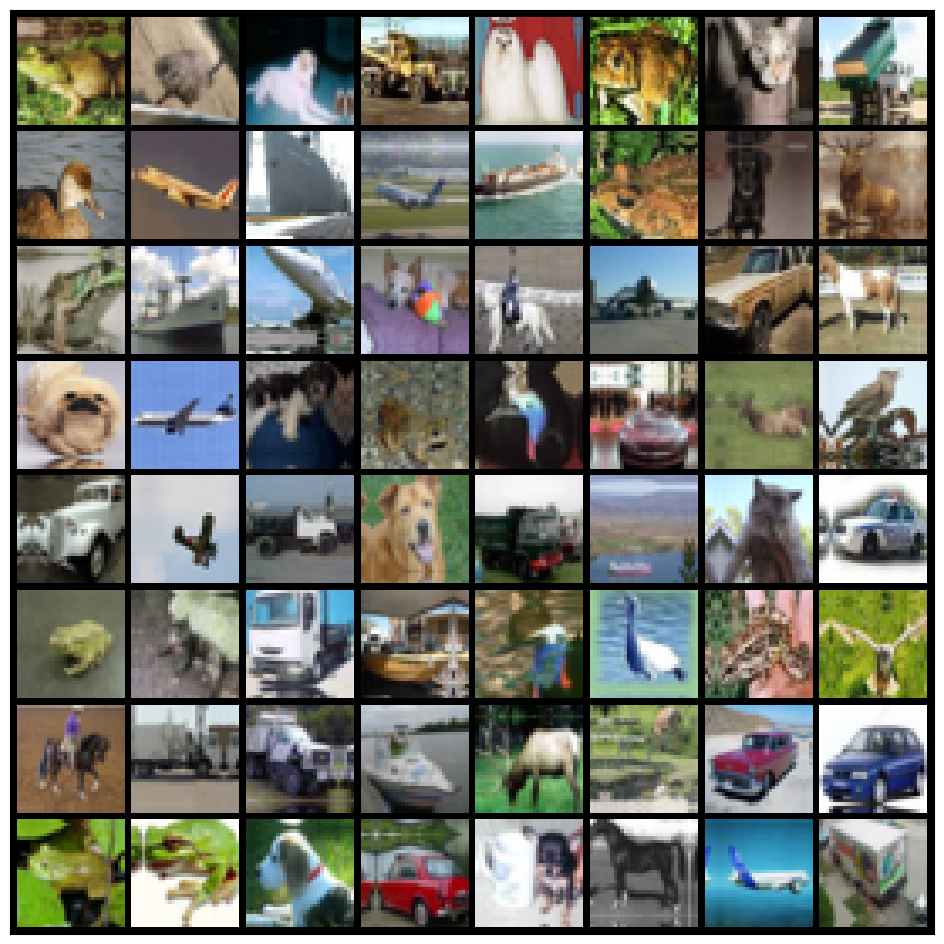

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
  # Pick GPU, if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # If the instance is a list/tuple, transfer each element to chosen device
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  # non_blocking=True doesn't block the execution of the host device until transfers complete

class DeviceDataLoader():
  # Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [ ]:
# Get the default device
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class BottleneckBlock(nn.Module):
    expansion = 4  # Bottleneck expands channels by 4x

    def __init__(self, in_planes, planes, stride=1):
        super(BottleneckBlock, self).__init__()
        # 1x1 convolution to reduce channels to 'planes'
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # 3x3 convolution with stride (spatial downsampling)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # 1x1 convolution to expand channels to 'planes * expansion'
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 40  # Initial channel size

        # Initial convolution (modified for CIFAR-10/32x32 input)
        self.conv1 = nn.Conv2d(3, 40, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(40)

        # Layers with Bottleneck blocks
        self.layer1 = self._make_layer(block, 40, layers[0], stride=1)   # 40 -> 40*4=160
        self.layer2 = self._make_layer(block, 80, layers[1], stride=2)   # 80 -> 80*4=320
        self.layer3 = self._make_layer(block, 144, layers[2], stride=2)  # 144 -> 144*4=576
        self.layer4 = self._make_layer(block, 176, layers[3], stride=2)  # 176 -> 176*4=704

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(176 * block.expansion, num_classes)  # 176*4=704

    def _make_layer(self, block, planes, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion  # Update in_planes for next blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def resnet50_light(num_classes=10, dropout_rate=0.5):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes=num_classes, dropout_rate=dropout_rate)

if __name__ == "__main__":
    model = resnet50_light(num_classes=10, dropout_rate=0.5)
    print(model)
    summary(model.cuda(), (3, 32, 32))  # Input shape for CIFAR-10

ResNet(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(40, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BottleneckBloc

In [ ]:
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [ ]:
r = 0.1

start_epoch = 1
number_of_epochs = 300
best_acc = 0


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02,
                      momentum= 0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=number_of_epochs)

In [ ]:
import time

def format_time(seconds):
    """Convert seconds to a readable format (hh:mm:ss)."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

In [ ]:
def train(epoch):
  print('\nEpoch: %d' % epoch)
  start_time = time.time()

  model.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(train_dl):
    # Move inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

  cur_time = time.time()
  epoch_time = cur_time - start_time
  print(f"Training Time : {format_time(epoch_time)}")

  return train_loss/(batch_idx+1), 100.*correct/total, get_lr(optimizer)

def test(epoch):
  global best_acc
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dl):
      # Move inputs and targets to the same device as the model
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    print('Saving..')
    state = {
        'net': model.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
    torch.save(state, './checkpoint/resnet_34_dropout_best.pth')
    best_acc = acc

  return test_loss/(batch_idx+1), 100.*correct/total


In [ ]:
def get_lr(optimizer):
    """Retrieve the current learning rate from the optimizer."""
    for param_group in optimizer.param_groups:
        return param_group['lr']  # Return the learning rate of the first param group


In [ ]:
train_losses = []
train_accuracies = []
train_lrs = []

test_losses = []
test_accuracies = []

for epoch in range(start_epoch, start_epoch + number_of_epochs):
  epoch_train_loss, epoch_train_accuracy, epoch_lr = train(epoch)
  train_losses.append(epoch_train_loss)
  train_accuracies.append(epoch_train_accuracy)
  train_lrs.append(epoch_lr)

  epoch_test_loss, epoch_test_accuracy = test(epoch)
  test_losses.append(epoch_test_loss)
  test_accuracies.append(epoch_test_accuracy)

  scheduler.step()
  print(f"Train Loss: {epoch_train_loss:.3f} | Train Accuracy: {epoch_train_accuracy:.3f}% | Test Loss: {epoch_test_loss:.3f} | Test Accuracy: {epoch_test_accuracy:.3f}%")


Epoch: 1
Training Time : 00:00:51
Saving..
Train Loss: 2.061 | Train Accuracy: 29.688% | Test Loss: 1.731 | Test Accuracy: 43.120%

Epoch: 2
Training Time : 00:00:51
Saving..
Train Loss: 1.539 | Train Accuracy: 44.532% | Test Loss: 1.257 | Test Accuracy: 53.880%

Epoch: 3
Training Time : 00:00:51
Saving..
Train Loss: 1.232 | Train Accuracy: 56.120% | Test Loss: 1.102 | Test Accuracy: 61.080%

Epoch: 4
Training Time : 00:00:52
Saving..
Train Loss: 1.040 | Train Accuracy: 63.392% | Test Loss: 0.884 | Test Accuracy: 69.100%

Epoch: 5
Training Time : 00:00:51
Train Loss: 0.896 | Train Accuracy: 68.838% | Test Loss: 0.893 | Test Accuracy: 68.850%

Epoch: 6
Training Time : 00:00:52
Saving..
Train Loss: 0.783 | Train Accuracy: 72.922% | Test Loss: 0.725 | Test Accuracy: 75.410%

Epoch: 7
Training Time : 00:00:52
Saving..
Train Loss: 0.699 | Train Accuracy: 75.910% | Test Loss: 0.672 | Test Accuracy: 77.030%

Epoch: 8
Training Time : 00:00:53
Saving..
Train Loss: 0.629 | Train Accuracy: 78.47

In [ ]:
# At the end of training (after the loop)
torch.save(model.state_dict(), 'final_model.pth')


In [ ]:
from google.colab import files

# Save the model (as you already did)
torch.save(model.state_dict(), 'final_model.pth')

# Download the saved model file
files.download('final_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
import numpy as np
import torch
def load_custom_test_set(filepath):
    # Open the pickle file and load the data
    with open(filepath, 'rb') as f:
        data = pickle.load(f, encoding='bytes')

    # Extract image data
    images = data[b'data']  # Shape: (10000, 32, 32, 3)

    # Fix Shape: Convert (32, 32, 3) → (3, 32, 32)
    images = np.transpose(images, (0, 3, 1, 2))  # New shape: (10000, 3, 32, 32)

    # Convert data to float32
    images = images.astype(np.float32) / 255.0  # Normalize to [0,1]

    # Convert to a PyTorch tensor
    images = torch.tensor(images, dtype=torch.float32)

    return images

# Load test images from the provided file path.
test_images = load_custom_test_set("/content/cifar_test_nolabel.pkl")
print("Loaded custom test set with shape:", test_images.shape)  # e.g., (10000, 3, 32, 32)


Loaded custom test set with shape: torch.Size([10000, 3, 32, 32])


In [ ]:
pkl_mean = [0.513, 0.497, 0.462]
pkl_std = [0.263, 0.260, 0.273]

normalize = transforms.Normalize(mean=pkl_mean, std=pkl_std)

def preprocess_images(images):
    # Loop over each image to apply normalization
    for i in range(images.shape[0]):
        images[i] = normalize(images[i])
    return images

test_images = preprocess_images(test_images)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(test_images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
# Load model
import pandas as pd
from google.colab import files
model = resnet50_light(num_classes=10, dropout_rate=0.5)
model.load_state_dict(torch.load('final_model.pth'))
model = model.to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)  # Match training configuration

model.eval()

# Generate predictions
all_ids = []
all_preds = []

with torch.no_grad():
    for batch_idx, (images,) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Create IDs (batch_idx * batch_size + index_in_batch)
        batch_ids = [str(batch_idx * 128 + i) for i in range(len(images))]

        all_ids.extend(batch_ids)
        all_preds.extend(preds.cpu().numpy())

# Create and save CSV
submission_df = pd.DataFrame({'ID': all_ids, 'Labels': all_preds})
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<ipython-input-104-c1ae46b60b00>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_model.pth'))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from google.colab import files

def compare_submissions(file1, file2):
    # Read both CSV files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Check basic structure
    if list(df1.columns) != list(df2.columns):
        print("⚠️ Column names don't match!")
        print(f"File1 columns: {df1.columns}")
        print(f"File2 columns: {df2.columns}")
        return

    # Merge dataframes on ID
    merged = df1.merge(df2, on='ID', suffixes=('_1', '_2'))

    # Calculate accuracy
    matches = (merged['Labels_1'] == merged['Labels_2']).sum()
    total = len(merged)
    accuracy = matches / total

    print(f"📊 Comparison Results:")
    print(f"Total rows compared: {total}")
    print(f"Matching labels: {matches} ({accuracy:.2%})")
    print(f"Non-matching labels: {total - matches}")

    # Show discrepancies
    if total - matches > 0:
        print("\n🔍 Sample discrepancies:")
        discrepancies = merged[merged['Labels_1'] != merged['Labels_2']]
        print(discrepancies.head(10))

    return accuracy

# Upload files
print("Upload first submission file:")
uploaded1 = files.upload()
file1_name = list(uploaded1.keys())[0]

print("\nUpload second submission file:")
uploaded2 = files.upload()
file2_name = list(uploaded2.keys())[0]

# Compare files
similarity = compare_submissions(file1_name, file2_name)

Upload first submission file:


Saving submission.csv to submission (6).csv

Upload second submission file:


Saving submission_sub.csv to submission_sub (4).csv
📊 Comparison Results:
Total rows compared: 10000
Matching labels: 8908 (89.08%)
Non-matching labels: 1092

🔍 Sample discrepancies:
    ID  Labels_1  Labels_2
17  17         8         0
22  22         5         7
28  28         9         3
32  32         0         3
52  52         1         0
55  55         1         8
78  78         9         8
88  88         1         2
91  91         5         3
99  99         3         5
